In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import csv
import nltk
import string
import pandas as pd
import numpy as np
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

BUILD THE DATA

In [3]:
import pandas as pd
path = 'ArticlesApril2017.csv'
df = pd.read_csv(path)
df = df.iloc[:50, :]
df.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...
2,NaN,58def9f57c459f24986d7c90,575,By THE EDITORIAL BOARD,article,Venezuela’s Descent Into Dictatorship,"['Venezuela', 'Politics and Government', 'Madu...",3,Editorial,22,2017-04-01 00:53:06,Unknown,A court ruling annulling the legislature’s aut...,The New York Times,Editorial,https://www.nytimes.com/2017/03/31/opinion/ven...
3,NaN,58defd317c459f24986d7c95,1374,By MICHAEL POWELL,article,Stain Permeates Basketball Blue Blood,"['Basketball (College)', 'University of North ...",3,Sports,1,2017-04-01 01:06:52,College Basketball,"For two decades, until 2013, North Carolina en...",The New York Times,News,https://www.nytimes.com/2017/03/31/sports/ncaa...
4,NaN,58df09b77c459f24986d7ca7,708,By DEB AMLEN,article,Taking Things for Granted,['Crossword Puzzles'],3,Games,0,2017-04-01 02:00:14,Unknown,In which Howard Barkin and Will Shortz teach u...,The New York Times,News,https://www.nytimes.com/2017/03/31/crosswords/...


In [4]:
corpus = df['snippet'].str.lower().tolist()

#corpus = data.lower().split("\n")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1 
word_index = tokenizer.word_index

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'a': 2, 'to': 3, 'of': 4, 'in': 5, 'and': 6, 'for': 7, 'that': 8, 'is': 9, 'from': 10, 'about': 11, 'on': 12, 'be': 13, 'you': 14, 'who': 15, 'have': 16, 'an': 17, 'this': 18, 'has': 19, 'it': 20, 'as': 21, 'its': 22, 'will': 23, 'but': 24, 'one': 25, 'people': 26, 'are': 27, 'been': 28, 'by': 29, 'at': 30, 'what': 31, 'should': 32, 'how': 33, 'court': 34, 'into': 35, 'him': 36, '”': 37, 'out': 38, 'say': 39, 'stand': 40, 'trump': 41, '—': 42, 'new': 43, 'even': 44, 'with': 45, 'may': 46, 'than': 47, 'senate': 48, 'times': 49, 'authority': 50, 'turning': 51, 'decades': 52, 'until': 53, 'still': 54, 'which': 55, 'us': 56, 'over': 57, 'women': 58, 'isn’t': 59, 'if': 60, 'another': 61, 'like': 62, 'big': 63, 'they': 64, 'anti': 65, 'look': 66, 's': 67, 'companies': 68, 'there': 69, 'something': 70, 'was': 71, 'her': 72, 'found': 73, 'most': 74, 'president': 75, 'did': 76, 'she': 77, 'again': 78, 'well': 79, 'other': 80, 'study': 81, 'had': 82, 'making': 83, 'professor': 84, 'nu

In [5]:
snippets = '\n'.join(df['snippet'])
print(type(snippets))
print(snippets)

<class 'str'>
One of the largest photo displays in Times history, of people who have fled Boko Haram, required an effort just as immense.
Meet the gang from under the bus.
A court ruling annulling the legislature’s authority represents a dangerous turning point for Venezuela.
For two decades, until 2013, North Carolina engaged in academic improprieties that benefited its student-athletes. The repercussions are still being felt.
In which Howard Barkin and Will Shortz teach us a lesson.
In this visually ravishing production, Bobby Cannavale steps into a part that has been waiting for him for decades.
For the author, this gleaming, complex city in British Columbia is “a rolling, improvisatory work in progress.”
About $13 million has been paid out over the years to address complaints from women about Mr. O’Reilly’s behavior. He denies the claims have merit.
Getting rid of mice isn’t easy, but it’s a co-op board’s responsibility if a building becomes infested.
A proposed “border adjustment”

In [6]:
for line in corpus:
   seqs = tokenizer.texts_to_sequences([line])[0]
print(seqs)

[571, 572, 3, 2, 90, 8, 573, 574, 68, 3, 575, 576, 577, 46, 13, 578, 3, 17, 44, 579, 580, 47, 581, 18, 582]


Generating N-Grams

In [7]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)): 
      n_gram_seqs = token_list[:i+1]
      input_sequences.append(n_gram_seqs)
print(len(input_sequences))
print(input_sequences[:10])

880
[[25, 4], [25, 4, 1], [25, 4, 1, 91], [25, 4, 1, 91, 92], [25, 4, 1, 91, 92, 93], [25, 4, 1, 91, 92, 93, 5], [25, 4, 1, 91, 92, 93, 5, 49], [25, 4, 1, 91, 92, 93, 5, 49, 94], [25, 4, 1, 91, 92, 93, 5, 49, 94, 4], [25, 4, 1, 91, 92, 93, 5, 49, 94, 4, 26]]


In [8]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
max_seq_length = max([len(x) for x in input_sequences])
input_seqs = np.array(pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre'))
print(max_seq_length)
print(input_seqs[:5])

35
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 25  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 25  4  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 25  4  1 91]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 25  4  1 91 92]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 25  4  1 91 92 93]]


In [10]:
x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print(x_values[:3])
print(labels[:3])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 25  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 25  4  1]]
[ 4  1 91]


Generate Glove Embeddings

In [13]:
path = 'glove.6B.100d.txt'
embeddings_index = {}
with open(path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coeffs
dict(list(embeddings_index.items())[0:2])

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [14]:
embeddings_matrix = np.zeros((total_words, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 8.3 MB/s eta 0:00:0000:0100:01


In [15]:
#Code for Visualization

#Write this after the Embedding matrix is created


import plotly.express as px

#Function to find the intersection of 2 lists
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3



#Dimensionality Reduction using TSNE
from sklearn.manifold import TSNE

words =  intersection(list(word_index.keys()), list(embeddings_index.keys()))
vectors = [embeddings_index[word] for word in words]

vectors = np.asarray(vectors)

tsne = TSNE(n_components=3, verbose=1, random_state=100)
z = tsne.fit_transform(vectors)



#Dataframe of words in 3 Dimensions
df_embed = pd.DataFrame()

df_embed['keys'] = words
df_embed["x1"] = z[:,0]
df_embed["x2"] = z[:,1]
df_embed["x3"] = z[:,2]


#Find frequency of each word in corpus and sort according to frequency
s = ''
for i in corpus:
    s = s + ' ' + i

freq = {}
for i in words:
    freq[i] = 0

for j in s.split():
    if j in freq.keys():
        freq[j] += 1

sorted_freq = dict(sorted(freq.items(), key=lambda x:x[1], reverse = True))     


#Update the Dataframe of words in 3 Dimensions with key frequency
df_embed['freq'] = 0

for i in list(sorted_freq.keys()):
    temp_index = df_embed[df_embed['keys'] == i].index.values[0]
    df_embed.loc[temp_index, 'freq'] = sorted_freq[i]


#Sort the Dataframe according Frequency of keys
df_embed_sorted = df_embed.sort_values(by = ['freq'], ascending = False)


#Plot 3 Dimensional Scatter Plot of 10 most frequent keys
fig = px.scatter_3d(df_embed_sorted.head(10), x='x1', y='x2', z='x3', text = 'keys', color = 'keys')
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 533 samples in 0.000s...
[t-SNE] Computed neighbors for 533 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 533 / 533
[t-SNE] Mean sigma: 1.612479
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.908417
[t-SNE] KL divergence after 1000 iterations: 1.241255


In [16]:
#Remove Stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

df_no_stopwords = df_embed.copy()

for i in range(len(df_no_stopwords)):
    for j in stop_words:
        if (df_no_stopwords.loc[i, "keys"] == j) or (df_no_stopwords.loc[i, "keys"] == '—'):
            df_no_stopwords.loc[i, "freq"] = 0

            
df_no_stopwords_sorted = df_no_stopwords.sort_values(by = ['freq'], ascending = False)


#Plot 3 Dimensional Scatter Plot of 10 most frequent keys that are not stopwords
fig = px.scatter_3d(df_no_stopwords_sorted.head(10), x='x1', y='x2', z='x3', text = 'keys', color = 'keys')
fig.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Define Validation Metric

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    return K.exp(K.mean(cross_entropy))

from sklearn.metrics import make_scorer
perplexity_scorer = make_scorer(perplexity, greater_is_better = False)

Model Building

In [18]:
from tensorflow.keras import layers
def create_model(use_bidirectional, num_lstm_units, dropout_rate, lr):
    if use_bidirectional == 'LSTM':
        model = tf.keras.Sequential()

        embed_layer = layers.Embedding(input_dim = total_words, output_dim = 100,
                                   input_length = max_seq_length-1, weights = [embeddings_matrix])
        model.add(embed_layer)

        model.add((layers.LSTM(num_lstm_units, return_sequences=True)))

        model.add(layers.Dropout(dropout_rate))

        model.add((layers.LSTM(num_lstm_units)))

        model.add(tf.keras.layers.Dropout(dropout_rate))

        model.add(tf.keras.layers.Dense(128, activation='relu'))

        model.add(tf.keras.layers.Dense(total_words , activation='softmax'))

        model.compile(optimizer = Adam(learning_rate = lr), loss = "categorical_crossentropy",  
                  metrics=["accuracy", perplexity])
    elif use_bidirectional == 'BILSTM':
        model = tf.keras.Sequential()

        embed_layer = tf.keras.layers.Embedding(input_dim = total_words, output_dim = 100,
                                                input_length = max_seq_length - 1,
                                                weights = [embeddings_matrix],
                                                trainable = False) # Freeze embedding weights

        model.add(embed_layer)

        model.add(Bidirectional(LSTM(num_lstm_units, return_sequences=True)))

        model.add(Bidirectional(LSTM(num_lstm_units)))

        model.add(Dense(128, activation='relu'))

        model.add(tf.keras.layers.Dropout(dropout_rate))

        # Add dense layer with softmax activation
        model.add(Dense(total_words, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = lr), metrics=["accuracy", perplexity])
    return model

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.1)

LSTM Model

In [ ]:
lstm_model = create_model('LSTM', 256, 0.2, 0.001)
lstm_model.summary()
history = lstm_model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=256)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 34, 100)           173100    
                                                                 
 lstm_98 (LSTM)              (None, 34, 256)           365568    
                                                                 
 dropout_73 (Dropout)        (None, 34, 256)           0         
                                                                 
 lstm_99 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_74 (Dropout)        (None, 256)               0         
                                                                 
 dense_98 (Dense)            (None, 128)               32896     
                                                                 
 dense_99 (Dense)            (None, 1731)            

In [ ]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 851.1 kB/s eta 0:00:00a 0:00:01


In [29]:
import pickle
# save the model to disk
filename = 'lstm_model.sav'
#pickle.dump(lstm_model, open(filename, 'wb'))
#pickle.dump(history.history, open('lstm_history.sav', 'wb'))
# load the model from disk
lstm_model = pickle.load(open(filename, 'rb'))
lstm_history = pickle.load(open('lstm_history.sav', 'rb'))

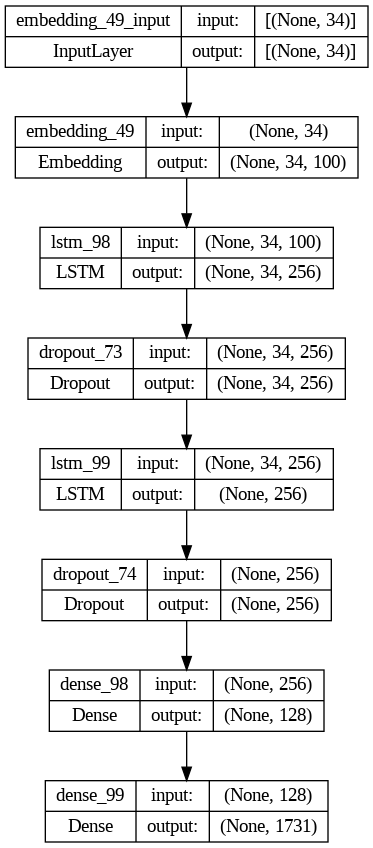

In [25]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

Bi-LSTM Model

In [ ]:
bilstm_model = create_model('BILSTM', 256, 0.2, 0.001)
bilstm_model.summary()
# Fit model
history = bilstm_model.fit(x_values, y_values, epochs=50, verbose=1)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 34, 100)           173100    
                                                                 
 bidirectional_50 (Bidirecti  (None, 34, 512)          731136    
 onal)                                                           
                                                                 
 bidirectional_51 (Bidirecti  (None, 512)              1574912   
 onal)                                                           
                                                                 
 dense_100 (Dense)           (None, 128)               65664     
                                                                 
 dropout_75 (Dropout)        (None, 128)               0         
                                                                 
 dense_101 (Dense)           (None, 1731)            

In [28]:
import pickle
# save the model to disk
filename = 'bilstm_model.sav'
#pickle.dump(lstm_model, open(filename, 'wb'))
#pickle.dump(history.history, open('lstm_history.sav', 'wb'))
# load the model from disk
bilstm_model = pickle.load(open(filename, 'rb'))
bilstm_history = pickle.load(open('bilstm_history.sav', 'rb'))

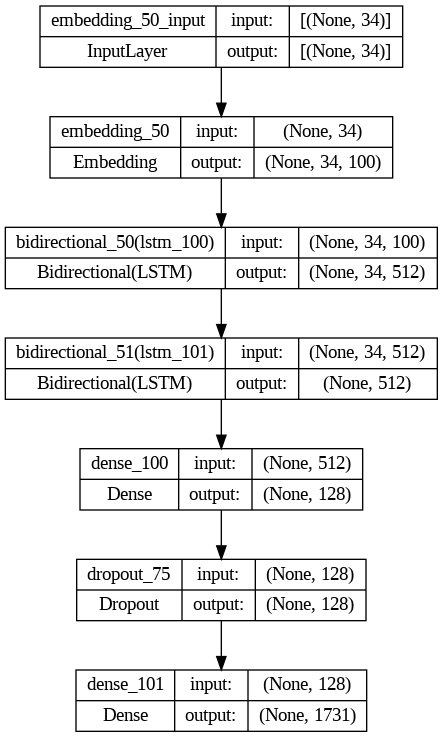

In [30]:
tf.keras.utils.plot_model(bilstm_model, show_shapes=True)

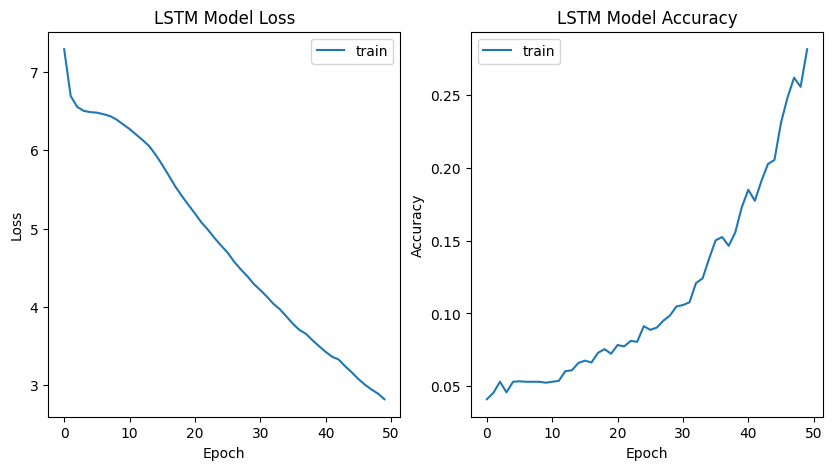

In [31]:
import matplotlib.pyplot as plt
# plot the training and validation loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot the loss
ax[0].plot(lstm_history['loss'], label='train')
ax[0].set_title('LSTM Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# plot the accuracy
ax[1].plot(lstm_history['accuracy'], label='train')
ax[1].set_title('LSTM Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

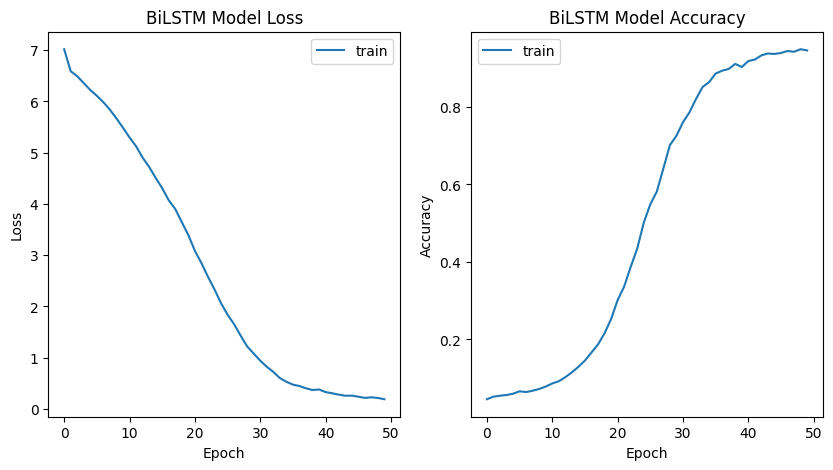

In [32]:
import matplotlib.pyplot as plt
# plot the training and validation loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot the loss
ax[0].plot(bilstm_history['loss'], label='train')
ax[0].set_title('BiLSTM Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# plot the accuracy
ax[1].plot(bilstm_history['accuracy'], label='train')
ax[1].set_title('BiLSTM Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

Ablation Study 

In [33]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameters to search over
param_grid = {
    'use_bidirectional':['LSTM', 'BILSTM'],
    'num_lstm_units': [64, 128],
    'dropout_rate': [0.2, 0.5],
    'lr':[0.01, 0.001] 
}

In [ ]:
# Create the GridSearchCV object
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 10, scoring = 'neg_log_loss', cv = 2)
grid_result = grid.fit(x_values, y_values, epochs = 20)

/var/folders/hw/krvc36_s5f704ddn9wvv0mz80000gn/T/ipykernel_44825/1620164384.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START dropout_rate=0.2, lr=0.01, num_lstm_units=64, use_bidirectional=LSTM
Epoch 1/20
55/55 [==============================] - 6s 61ms/step - loss: 7.0742 - accuracy: 0.0415 - perplexity: 1233.8036
Epoch 2/20
55/55 [==============================] - 3s 53ms/step - loss: 6.3512 - accuracy: 0.0529 - perplexity: 603.3488
Epoch 3/20
55/55 [==============================] - 3s 52ms/step - loss: 6.0584 - accuracy: 0.0500 - perplexity: 451.8264
Epoch 4/20
55/55 [==============================] - 4s 65ms/step - loss: 5.9110 - accuracy: 0.0529 - perplexity: 382.8526
Epoch 5/20
55/55 [==============================] - 3s 50ms/step - loss: 5.7913 - accuracy: 0.0506 - perplexity: 343.3006
Epoch 6/20
55/55 [==============================] - 3s 51ms/step - loss: 5.6500 - accuracy: 0.0654 - perplexity: 306.3946
Epoch 7/20
55/55 [==============================] - 3s 52ms/step - loss: 5.5208 - accuracy: 0.0745 - perplexity: 262

In [34]:
import joblib

#save your model or results
#joblib.dump(grid, 'grid_model.pkl')

#load your model for further usage
grid = joblib.load("grid_model.pkl")

In [35]:
# Print the best hyperparameters and accuracy score
print("Best hyperparameters:", grid.best_params_)

Best hyperparameters: {'dropout_rate': 0.5, 'lr': 0.01, 'num_lstm_units': 128, 'use_bidirectional': 'BILSTM'}


In [36]:
import pandas as pd

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("dropoutRate_learnRate_lstmUnits_Model")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
dropoutRate_learnRate_lstmUnits_Model,,,,
0.5_0.01_128_BILSTM,"{'dropout_rate': 0.5, 'lr': 0.01, 'num_lstm_un...",1,-12.228630,0.384587
0.5_0.001_64_LSTM,"{'dropout_rate': 0.5, 'lr': 0.001, 'num_lstm_u...",2,-12.323918,0.207779
0.2_0.001_64_LSTM,"{'dropout_rate': 0.2, 'lr': 0.001, 'num_lstm_u...",3,-12.501447,0.398874
0.5_0.001_128_LSTM,"{'dropout_rate': 0.5, 'lr': 0.001, 'num_lstm_u...",4,-12.701998,0.311554
0.5_0.001_64_BILSTM,"{'dropout_rate': 0.5, 'lr': 0.001, 'num_lstm_u...",5,-12.754429,0.081893
0.5_0.001_128_BILSTM,"{'dropout_rate': 0.5, 'lr': 0.001, 'num_lstm_u...",6,-12.938389,0.181381
0.2_0.001_128_LSTM,"{'dropout_rate': 0.2, 'lr': 0.001, 'num_lstm_u...",7,-13.075570,0.215752
0.5_0.01_64_BILSTM,"{'dropout_rate': 0.5, 'lr': 0.01, 'num_lstm_un...",8,-13.178693,0.409702
0.5_0.01_64_LSTM,"{'dropout_rate': 0.5, 'lr': 0.01, 'num_lstm_un...",9,-13.193778,0.250823


In [37]:
results_df[['perplexity']] = results_df[['mean_test_score']].apply(lambda x : np.exp(-x)/1000)

In [38]:
final_results = results_df[['perplexity', 'mean_test_score']]
final_results

,perplexity,mean_test_score
dropoutRate_learnRate_lstmUnits_Model,,
0.5_0.01_128_BILSTM,204.562750,-12.228630
0.5_0.001_64_LSTM,225.014095,-12.323918
0.2_0.001_64_LSTM,268.725868,-12.501447
0.5_0.001_128_LSTM,328.403255,-12.701998
0.5_0.001_64_BILSTM,346.081345,-12.754429
0.5_0.001_128_BILSTM,415.978393,-12.938389
0.2_0.001_128_LSTM,477.142079,-13.075570
0.5_0.01_64_BILSTM,528.973395,-13.178693
0.5_0.01_64_LSTM,537.013254,-13.193778


In [39]:
final_results.reset_index(inplace=True)

In [40]:
from tensorflow.keras import backend as K

def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp(K.mean(cross_entropy))
    return perplexity

In [41]:
# lstm_model.save('lstm_model.h5')
# lstm_model = tf.keras.models.load_model('lstm_model.h5',custom_objects={'perplexity': perplexity})

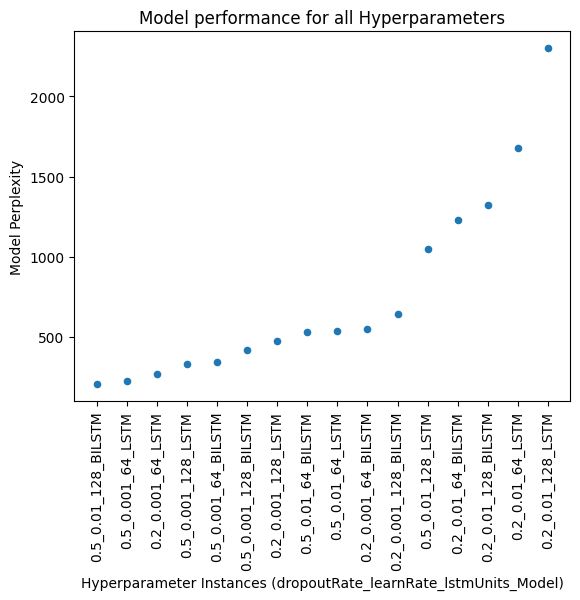

In [42]:
import matplotlib.pyplot as plt
# create the scatter plot
ax = final_results.plot(kind='scatter', x = 'dropoutRate_learnRate_lstmUnits_Model', y = 'perplexity')

# rotate the x-axis labels by 90 degrees
plt.title('Model performance for all Hyperparameters')
plt.xticks(rotation=90)
plt.xlabel('Hyperparameter Instances (dropoutRate_learnRate_lstmUnits_Model)')
plt.ylabel('Model Perplexity')
# show the plot
plt.show()

PREDICTION USING LSTM

In [43]:
seed_text = "I don't think it should be a"
next_words = 10
#Prediction
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')
    predicted = lstm_model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted, axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    print(seed_text)

I don't think it should be a bobby
I don't think it should be a bobby 
I don't think it should be a bobby  
I don't think it should be a bobby   
I don't think it should be a bobby    
I don't think it should be a bobby     
I don't think it should be a bobby      
I don't think it should be a bobby       
I don't think it should be a bobby        
I don't think it should be a bobby         


PREDICTION USING BiLSTM

In [44]:
seed_text = "I don't think it should be a"
next_words = 10
#Prediction
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')
    predicted = bilstm_model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted, axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    print(seed_text)

I don't think it should be a watch
I don't think it should be a watch about
I don't think it should be a watch about 
I don't think it should be a watch about  
I don't think it should be a watch about   
I don't think it should be a watch about    
I don't think it should be a watch about     
I don't think it should be a watch about      
I don't think it should be a watch about       
I don't think it should be a watch about        
